Import Statement

In [ ]:
#Import the necessary packages
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

Some Code for later plotting

In [ ]:
#Some plotting functions
def convert_flux_units(input_array, wavelength_array, convert_to='mujy'):
    """
    Convert between erg/s/cm^2/Å and microjanskys (µJy).
    
    Parameters
    ----------
    input_array : array-like
        Flux in erg/s/cm^2/Å.
    wavelength_array : array-like
        Wavelengths in Å.
    convert_to : str, optional
        Either 'mujy' (default) or 'flam' to specify the output units.

    Returns
    -------
    array-like
        Converted flux array.
    """
    c = 2.9979e18  # speed of light in Å/s
    if convert_to == 'mujy':
        return input_array * (wavelength_array**2) / c * 1e29
    elif convert_to == 'flam':  # flam = f_lambda = erg/s/cm^2/Å
        return input_array * c / (wavelength_array**2) / 1e29
    else:
        raise ValueError("convert_to must be either 'mujy' or 'flam'")

def plot_fitted_spectrum(bagpipes_fit,yscale = 'log'):
    try:
        bagpipes_fit.posterior.get_advanced_quantities()
    except Exception:
        print('Didnt get adv. quantities')
    #Get the spectral wavelengths of the bagpipes fit
    phot_wavelengths = bagpipes_fit.posterior.galaxy.photometry[:,0]
    #Dealing with the predicted photometry
    predicted_flux = convert_flux_units(np.percentile(bagpipes_fit.posterior.samples['photometry'],50,axis = 0),phot_wavelengths,convert_to = 'mujy')
    raw_predicted_flux_err_up = np.percentile(bagpipes_fit.posterior.samples['photometry'],84,axis = 0)
    predicted_flux_err_up = convert_flux_units(raw_predicted_flux_err_up,phot_wavelengths)
    raw_predicted_flux_err_down = np.percentile(bagpipes_fit.posterior.samples['photometry'],16,axis = 0)
    predicted_flux_err_down = convert_flux_units(raw_predicted_flux_err_down,phot_wavelengths)

    #Dealing with observed photometry
    observed_flux = convert_flux_units(bagpipes_fit.posterior.galaxy.photometry[:,1],phot_wavelengths,convert_to = 'mujy')
    observed_flux_err = convert_flux_units(bagpipes_fit.posterior.galaxy.photometry[:,2],phot_wavelengths,convert_to = 'mujy')

    #Dealing with spectrum
    redshift =  bagpipes_fit.fitted_model.model_components['redshift']
    med_spec = np.median(bagpipes_fit.posterior.samples['spectrum_full'],axis = 0)
    spec_wavelengths = bagpipes_fit.posterior.model_galaxy.wavelengths*(1+redshift)
    spectral_fluxes = convert_flux_units(med_spec,spec_wavelengths)
    spec_84 = convert_flux_units(np.percentile(bagpipes_fit.posterior.samples['spectrum_full'],84,axis = 0),spec_wavelengths)
    spec_16 = convert_flux_units(np.percentile(bagpipes_fit.posterior.samples['spectrum_full'],16,axis = 0),spec_wavelengths)


    #Plot 
    plt.errorbar(phot_wavelengths,observed_flux,observed_flux_err,label = 'Real',linestyle = '',marker = 'o')
    plt.errorbar(phot_wavelengths,predicted_flux,lolims = predicted_flux_err_down,uplims=predicted_flux_err_up,label = 'Modelled',color = 'black',linestyle = '',marker = 's',\
                 alpha = 0.7, markerfacecolor="None")
    plt.plot(spec_wavelengths,spectral_fluxes,alpha = 0.5,color = 'orange')
    plt.plot(spec_wavelengths,spec_84,alpha = 0.5,color = 'orange',linestyle = ':')
    plt.plot(spec_wavelengths,spec_16,alpha = 0.5,color = 'orange',linestyle = ':')
    plt.yscale(yscale)
    plt.xscale('log')
    plt.legend()
    plt.xlabel(r'Wavelength (\AA)')
    plt.ylabel(r'Flux $(\mu \mathrm{Jy})$')
    # plt.xlim(1000,1e5)
    # plt.ylim(10,3e2)

   # Limit x and y to photometry range
    x_padding = 0.1  # 10% on each side
    y_padding = 0.5  # 20% headroom

    x_min = np.min(phot_wavelengths)
    x_max = np.max(phot_wavelengths)
    plt.xlim(x_min * (1 - x_padding), x_max * (1 + x_padding))

    # Use only photometry for y-limits
    all_phot_flux = np.concatenate([
        observed_flux - observed_flux_err,
        observed_flux + observed_flux_err,
        predicted_flux_err_down,
        predicted_flux_err_up,
    ])
    all_phot_flux = all_phot_flux[all_phot_flux > 0]  # Avoid issues with log scale

    y_min = np.min(all_phot_flux)
    y_max = np.max(all_phot_flux)
    plt.ylim(y_min * (1 - y_padding), y_max * (1 + y_padding))

    plt.show()

def plot_star_formation_history(bagpipes_fit,label = None,color = 'black'):
    #Get the redshift
    redshift =  bagpipes_fit.fitted_model.model_components['redshift']
    age_of_universe = pipes.utils.cosmo.age(redshift).value*1e9
    #Get the lookback time
    lookback_time = (bagpipes_fit.posterior.sfh.ages)/1e9
    #Get the different percentiles of the star formation history
    sfrs = np.median(bagpipes_fit.posterior.samples['sfh'],axis = 0)
    sfrs_84 = np.percentile(bagpipes_fit.posterior.samples['sfh'],84,axis = 0)
    sfrs_16 = np.percentile(bagpipes_fit.posterior.samples['sfh'],16,axis = 0)
    #Plot
    plt.xscale('log')
    plt.plot(lookback_time[lookback_time<age_of_universe],sfrs[lookback_time<age_of_universe],color = color,label = label)
    plt.fill_between(lookback_time[lookback_time<age_of_universe],sfrs_84[lookback_time<age_of_universe],sfrs_16[lookback_time<age_of_universe],alpha = 0.3,color = color)
    plt.xlabel('Lookback Time (Gyr)')
    plt.ylabel('SFR')
    plt.yscale('log')
    plt.xlim(1e-3,max(lookback_time))

Bagpipes Fitting

In [ ]:
#These bins are in Myr and defined in logarithmic space
#Last bin set so neither goes over the age of the universe (according to Bagpipes cosmology)
bin_edges = [1.0,
 3.1622776601683795,
 31.62277660168379,
 316.22776601683796,
 3162.277660168379,
 12800.0]

In [ ]:
def create_fit_instructions(redshift,bins = bin_edges):
    #Make Bagpipes fit instructions from the given z and bins

    #We try to be as uninformative as possible

    #Choose Salim dust type for flexible Rv
    dust = {}
    dust["type"] = "Salim"
    dust["Av"] = (0., 4.)
    dust['delta'] = (-1.6,0.4) #Choice from Meldorf et. al. 23
    dust['B'] = 0.

    # Dust emission parameters
    dust["qpah"] = (1.,4.5)          # PAH mass fraction
    dust["umin"] = (0.1,25)        # Lower limit of starlight intensity distribution
    dust['umin_prior'] = 'log_10'
    dust["gamma"] = (1e-4,0.01)       # Fraction of stars at umin
    dust['gamma_prior'] = 'log_10'

    # #Nebular emission
    nebular = {"logU": (-4, -2)}

    #Set other instructions
    fit_instructions = {} 
    fit_instructions["dust"] = dust
    fit_instructions["nebular"] = nebular
    fit_instructions["t_bc"] = (0.001,0.01) #The max age for star formation
    fit_instructions['redshift'] = redshift
    
    bin_edges = bins

    continuity = {
        "massformed": (0., 13.),
        "metallicity": (0.1, 2.),
        "bin_edges": bin_edges,
    }

    for i in range(1, len(bin_edges)-1):
        continuity[f"dsfr{i}"] = (-10., 10.)
        continuity[f"dsfr{i}_prior"] = "student_t"
        continuity["metallicity_prior"] = "log_10"

    fit_instructions["continuity"] = continuity    

    return fit_instructions

In [ ]:
#The names (to name the bagpipes runs)
snia_name = 'SN2020aeth'
snic_name = 'SN2020aauc'

#The redshifts of the two supernovae
snia_redshift = 0.048
snic_redshift = 0.033

In [ ]:
#Bagpipes needs a function for getting the photometry
def get_photometry(name,include_euclid=True):
    if include_euclid:
        return np.load(f'{name}_LSST_Euclid.npy')
    else:
        return np.load(f'{name}_LSST.npy')

In [ ]:
#Define the filters (as in the file in your directory)
def get_filters(include_euclid = True):
    all_filters = ['Filters_Euclid_LSST/LSST/LSST.u.par','Filters_Euclid_LSST/LSST/LSST.g.par','Filters_Euclid_LSST/LSST/LSST.r.par','Filters_Euclid_LSST/LSST/LSST.i.par',\
    'Filters_Euclid_LSST/LSST/LSST.z.par','Filters_Euclid_LSST/Euclid/NISP.Y.par','Filters_Euclid_LSST/Euclid/NISP.J.par',\
        'Filters_Euclid_LSST/Euclid/NISP.H.par']

    lsst_filters = ['Filters_Euclid_LSST/LSST/LSST.u.par','Filters_Euclid_LSST/LSST/LSST.g.par','Filters_Euclid_LSST/LSST/LSST.r.par','Filters_Euclid_LSST/LSST/LSST.i.par',\
        'Filters_Euclid_LSST/LSST/LSST.z.par']
    if include_euclid:
        return all_filters
    else:
        return lsst_filters

In [ ]:
#Create the fit instructions (the only real difference is the redshift)
fit_instructions_ia = create_fit_instructions(snia_redshift)
fit_instructions_ic = create_fit_instructions(snic_redshift)

In [ ]:
#Use this function to run a bagpipes fit
def fit_bagpipes(name,redshift,include_euclid = True,pool = 8,n_live = 500):
    if include_euclid:
        run_name = f'{name}_LSST_Euclid'
    else:
        run_name = f'{name}_LSST'
    fit_instructions = create_fit_instructions(redshift)
    filters = get_filters(include_euclid)
    galaxy = pipes.galaxy(name,partial(get_photometry,include_euclid = include_euclid),spectrum_exists = False, filt_list = filters)
    fit = pipes.fit(galaxy,fit_instructions=fit_instructions,run = run_name)
    fit.fit(verbose = True,sampler = 'nautilus',pool = pool,n_live = n_live)
    return fit

In [ ]:
#Run your fits for euclid and no euclid data
snia_no_euclid = fit_bagpipes(snia_name,snia_redshift,include_euclid = False)
snia_euclid = fit_bagpipes(snia_name,snia_redshift,include_euclid = True)

snic_no_euclid = fit_bagpipes(snic_name,snic_redshift,include_euclid = False)
snic_euclid = fit_bagpipes(snic_name,snic_redshift,include_euclid = True)


Bagpipes: fitting object SN2020aeth

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Finished  | 23     | 3        | 4        | 26312    | N/A    | 4271  | +172.51  

Completed in 88.4 seconds.

Parameter                        

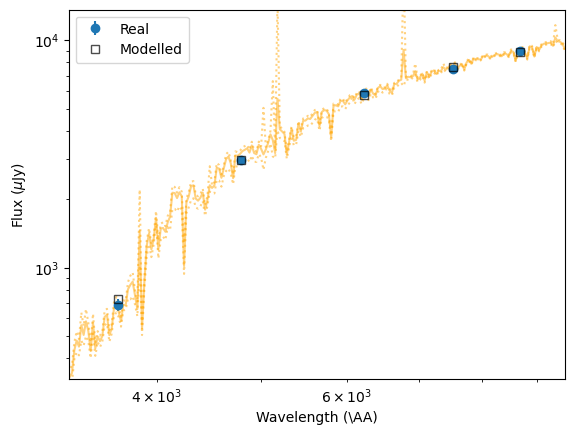

In [ ]:
# Plot the fitted spectrum
plot_fitted_spectrum(snic_no_euclid)

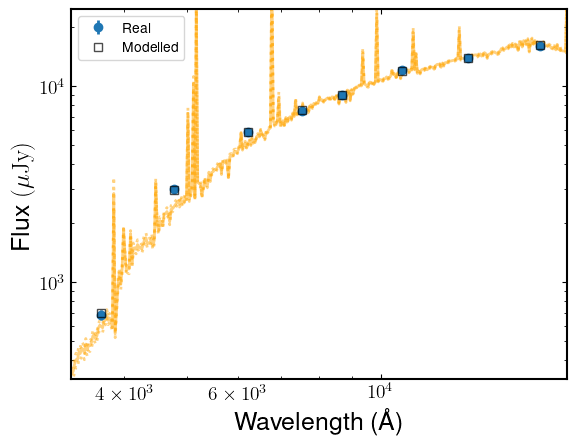

In [ ]:
#Plot the other fitted spectrum
plot_fitted_spectrum(snic_euclid)

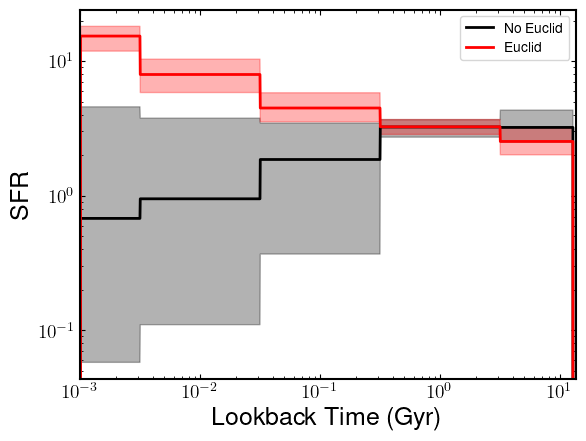

In [ ]:
#Plot the two star formation histories
plot_star_formation_history(snic_no_euclid,label = 'No Euclid')
plot_star_formation_history(snic_euclid,label = 'Euclid',color = 'red')
plt.legend()